### ***Initializing and Importing Packages***

In [2]:
using Plots, DataFrames, StatsBase, Plots.PlotMeasures, LaTeXStrings, CSV, JLD, ProgressMeter, Dates, NPZ, GraphRecipes

DataDir = "../../Data/"
FigsDir = "../../Figs/"

include("Mods.jl")

theme(:dark)
Plots.default(titlefontsize=12, tickfontsize=10, labelfontsize=12, legendfontsize=9,
    rightmargin=5mm, bottommargin=5mm, topmargin=5mm, leftmargin=5mm,
    fontfamily="Computer Modern", frame=:box, label=nothing)

### ***Get and import data***

In [183]:
# API_Key = "ADDB1242-D8BF-4A28-AC47-EC88A728259D"
API_Key = "9AE8E65E-79A6-415F-A1E0-4D167655CAEB"
# API_Key = "D0E92A88-20CE-4539-902F-19F09AE2A8A8"

# Symbols = String["ETH", "BTC", "XRP", "DASH", "NEO", "BNB",
#     "LSK", "XLM", "EOS", "LTC", "XEM", "USDT", "DOGE",
#     "XMR", "ETC", "BCH", "OMG", "ADA", "TRX"];

# for Sym ∈ Symbols
#     StatsMods.GetData(Sym; Period="5MIN", StartDate=DateTime(2022, 01, 31), EndDate=DateTime(2022, 02, 4), api_key=API_Key);
# end

Symbols = String["BTC",#= "DOGE", "ETC", =#"ETH", "XRP", "DASH", "NEO",
    "LSK", "EOS", "LTC", "XEM", "USDT",
    "XMR", "ADA", "TRX"];

CoinsData = Vector[]

for Sym ∈ Symbols
    push!(CoinsData, StatsMods.LoadData(Sym; Period="5MIN");)
end

In [211]:
MA_Data = Vector[]
LMT = 15
ND = length(CoinsData[1][1])
for Data ∈ CoinsData
    MA_Data = push!(MA_Data, [mean(Data[3][t-LMT:t+LMT]) for t ∈ LMT+1:ND-LMT-1])
end

In [212]:
ACMatix = zeros(Int, length(Symbols), length(Symbols))

for i ∈ 1:length(Symbols)
    for j ∈ 1:length(Symbols)
        if i != j
            ACMatix[i, j] = findfirst(x -> x <= 1 / ℯ, autocor(MA_Data[i] .- MA_Data[j], 1:500))
        end
    end
end

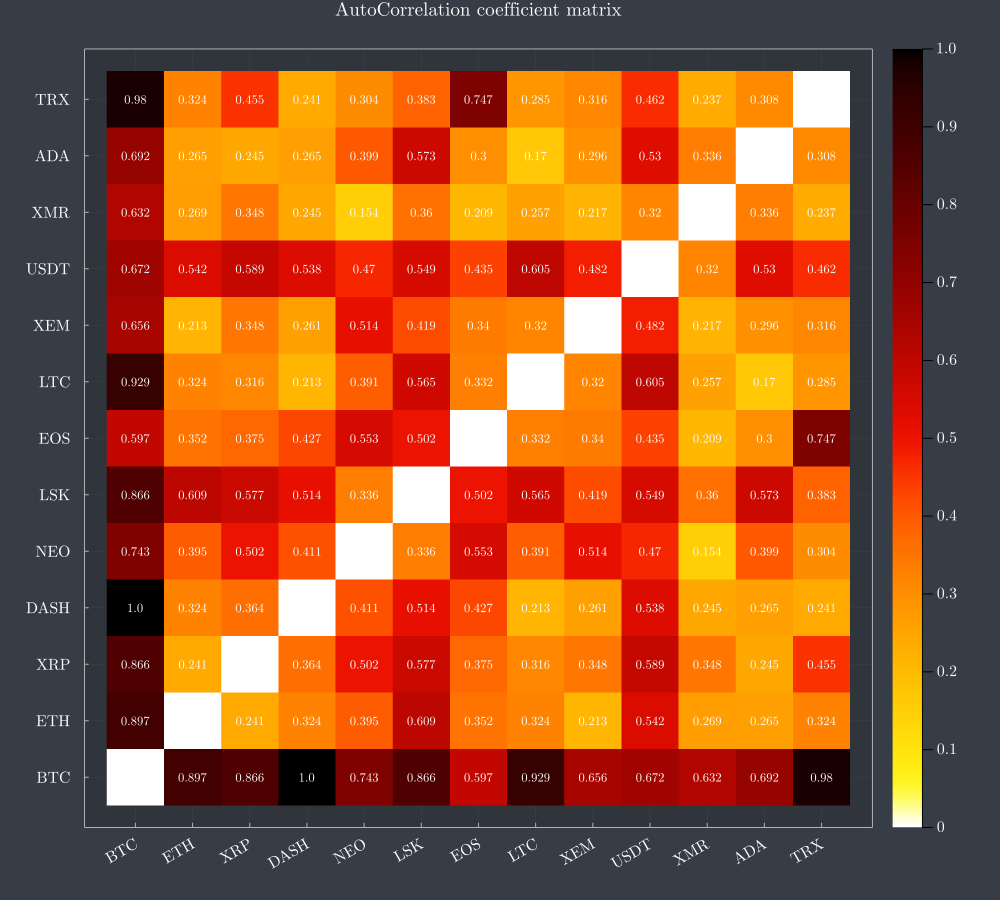

In [215]:
ScaledACM = ACMatix / maximum(ACMatix)

AdjCritics = x -> x >= minimum(ScaledACM[2:end, 1]) ? 1 : 0

ACAC = AdjCritics.(ScaledACM)
# npzwrite("../Python-lang/AdjMat.npz", ACAC)

AutoCorPlot = begin
    StatsMods.matrixmap(Symbols, Symbols, ScaledACM, annotationargs=(8, "Arial", :White), size=(1000, 900), c=cgrad(rev=true))
    plot!(title="AutoCorrelation coefficient matrix", rightmargin=5mm, bottommargin=5mm, topmargin=5mm, leftmargin=5mm)
end
savefig(AutoCorPlot, FigsDir * "S6-AutoCorPlot.pdf")
display(AutoCorPlot)

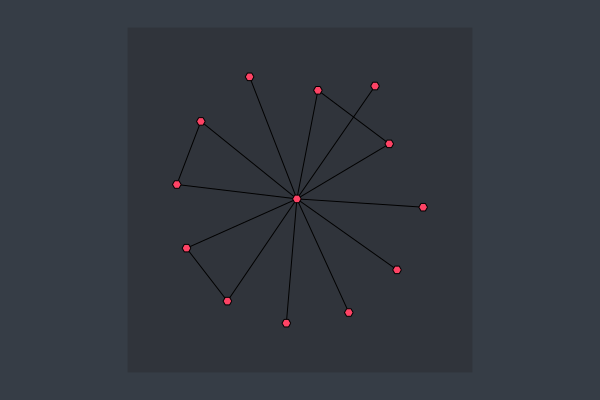

In [214]:
graphplot(ACAC, curves=false)